<a href="https://colab.research.google.com/github/RubinDaija/epfl-ada-2019-project/blob/master/sena_violations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Necessary Imports**

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from scipy import stats
from folium.plugins import MarkerCluster
import warnings
import folium
import zipfile

In [160]:
#-- Uncomment this if using Google Colab / Comment this if using Jupyter Lab --#

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Project_2/food-inspections.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [161]:
#-- Uncomment this if using Jupyter Lab / Comment this if using Google Colab --#
'''
zf = zipfile.ZipFile('chicago_dropped.zip')
df = pd.read_csv(zf.open('chicago_dropped/food_inspections.csv'))
'''

"\nzf = zipfile.ZipFile('chicago_dropped.zip')\ndf = pd.read_csv(zf.open('chicago_dropped/food_inspections.csv'))\n"

# **Data Analysis**

### **Number of Unique Facilities**

In [162]:
df_unique = df.groupby(['Latitude','Longitude','DBA Name']).count()
print("Number of unique facilities: " + str(df_unique.shape[0]))

Number of unique facilities: 27068


### **Facility Type vs. Average Risk**


We analyzed the relationship between the type of facility and the average risk of that facility over all inspections:

In [0]:
# Aggregate data over Facility Type
grouped_fac = df.groupby('Facility Type')

In [164]:
# Compute average risk of each type of facility
grouped_fac_risk_mean = pd.DataFrame(grouped_fac['Risk'].mean()).reset_index()
grouped_fac_risk_mean.head()

,Facility Type,Risk
0,ADULT FAMILY CARE CENTER,1.00000
1,AIRPORT LOUNGE,1.50000
2,ART GALLERY,3.00000
3,ASSISTED LIVING/NURSING HOME,1.00000
4,BAKERY,1.62949


In [165]:
# Compute number of facilities in each type of facility
fac_dist = pd.DataFrame(grouped_fac.count()['Risk']).rename(columns={'Risk':'Counts'}).sort_values(by='Counts',ascending=False).reset_index()
print("Number of different types of facilities :" + str(fac_dist.size))
fac_dist.head(100)

Number of different types of facilities :236


,Facility Type,Counts
0,RESTAURANT,131852
1,RETAIL STORE,25635
2,SCHOOL,12054
3,DAYCARE,9537
4,BAKERY,2923
...,...,...
95,FOOD BOOTH,2
96,VENDING MACHINE,2
97,VFW HALL,2
98,BOYS AND GIRLS CLUB,2


When we plotted the number of facilities in each type of facility vs. their average risk score, we observed no correlation between the two. We observed that the facility type with the highest number of facilities (i.e. restaurant) has a very high average risk score:

### **Facility Type Distribution**

From the bar plot below, we can clearly observe the skewed distribution in Facility Type. Most of our data consists of restaurant, grocery store, and school types of facilities:

Text(0, 0.5, 'Facility Types')

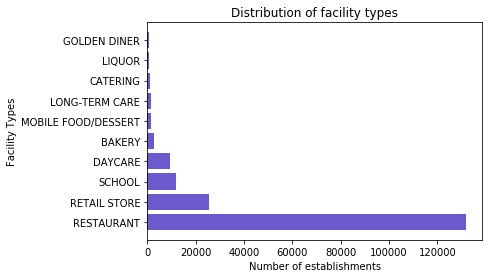

In [166]:
plt.barh(fac_dist.head(10)['Facility Type'],fac_dist.head(10)['Counts'], color='slateblue')
plt.title('Distribution of facility types')
plt.xlabel('Number of establishments')
plt.ylabel('Facility Types')

### **Number of Facilities in a Type vs. Average Risk Score**

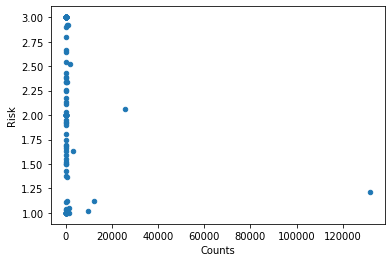

In [167]:
# Perform inner merge on number of facilities and their risk scores 
merged_inner = pd.merge(left=fac_dist,right=grouped_fac_risk_mean,left_on='Facility Type',right_on='Facility Type')
# Scatter plot: number of facilities in each type (i.e. facility type) vs. average risk score
merged_inner.plot.scatter(x='Counts', y='Risk')

We realized that the dataset is unbalanced in terms of number of Facility Types, where there are some Facility Types with very few instances. The types of facilities with very few instances would provide us with little to no information. Hence, we decided to analyze the 50 most frequent type of facilities and drop the others:

In [168]:
print("Number of entries before removing facility types with few instances: " + str(df.size))
df = df[df['Facility Type'].isin(list(fac_dist['Facility Type'])[:50])]
print("Number of entries after removing facility types with few instances: " + str(df.size))

Number of entries before removing facility types with few instances: 3074928
Number of entries after removing facility types with few instances: 3071184


Out of business facilities:

In [169]:
# Out of business facilities
df_oob = df[df.Results.str.contains("Out of Business",na=False)]
df_oob
# Grouped by the facilities
df_oob_unique = df_oob.groupby(['Latitude','Longitude','DBA Name']).count()
df_oob_unique.shape

(12083, 13)

###**Year analysis**

In [170]:
df_oob['year'] = df_oob['Inspection Date'].apply(lambda x: x.split('-')[0])
df_oob['month'] = df_oob['Inspection Date'].apply(lambda x: x.split('-')[1])
df_oob.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Regions,year,month
32,2352681,BAR-B-Q TONITE,BAR-B-Q TONITE,2563933.0,RESTAURANT,1,6348 N ARTESIAN AVE,60659.0,2019-12-03T00:00:00.000,CANVASS,Out of Business,NaN,41.997335,-87.691240,"{'latitude': '-87.69123961702296', 'longitude'...",WEST RIDGE,2019,12
39,2352679,ZAIQA RESTAURANT,ZAIQA RESTAURANT,2632018.0,RESTAURANT,1,2245 W DEVON AVE,60659.0,2019-12-03T00:00:00.000,CANVASS,Out of Business,NaN,41.997674,-87.686756,"{'latitude': '-87.6867563084304', 'longitude':...",WEST RIDGE,2019,12
49,2352524,TC HOTDOGS,TC HOTDOGS,1954116.0,RESTAURANT,2,1740 N KOSTNER AVE,60639.0,2019-12-02T00:00:00.000,CANVASS,Out of Business,NaN,41.912770,-87.736348,"{'latitude': '-87.7363483567106', 'longitude':...",HUMBOLDT PARK,2019,12
73,2352554,EAT & DRINK,EAT & DRINK,2069092.0,RESTAURANT,1,4649 N DAMEN AVE,60625.0,2019-12-02T00:00:00.000,CANVASS,Out of Business,NaN,41.966583,-87.678975,"{'latitude': '-87.67897535059605', 'longitude'...",LINCOLN SQUARE,2019,12
101,2352437,LABRIOL BAKERY AND CAFE,LABRIOLA BAKERY AND CAFE,2374837.0,BAKERY,2,1237 W FULTON MARKET,60607.0,2019-11-27T00:00:00.000,CANVASS,Out of Business,NaN,41.886547,-87.658324,"{'latitude': '-87.6583238753014', 'longitude':...",NEAR WEST SIDE,2019,11


In [0]:
df_year = df_oob.groupby("year").count()['Results'].reset_index().rename(columns={'Results':'Count'})

<BarContainer object of 10 artists>

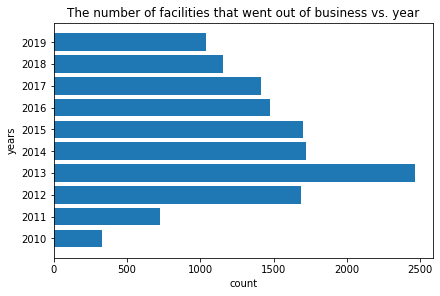

In [172]:
fig, axs = plt.subplots(1, 1, constrained_layout=True)
axs.set_title('The number of facilities that went out of business vs. year')
axs.set_xlabel('count')
axs.set_ylabel('years')
axs.barh(df_year['year'],df_year['Count'])

In the plot above, we can see that year 2013 is the year where the number of closed down facilities peaks. Therefore, we wil analyse the year 2013.

In [0]:
df_oob2013 = df_oob[df_oob.year.str.contains("2013",na=False)]
df_oob_not2013 = df_oob[~df_oob.year.str.contains("2013",na=False)]

In [174]:
df_oob2013.groupby("Regions").count().rename(columns={'Results':'Counts'}).sort_values(by='Counts',ascending=False)['Counts'].reset_index().head(15)

,Regions,Counts
0,LAKE VIEW,173
1,LOOP,159
2,NEAR NORTH SIDE,124
3,LINCOLN PARK,117
4,NEAR SOUTH SIDE,114
5,WEST TOWN,97
6,NEAR WEST SIDE,91
7,LOGAN SQUARE,77
8,AUSTIN,74
9,WEST RIDGE,59


As we can see from the code above, there are around 20 thousand facilities that dont have as much inspections as the others. As a result, data set is more balanced now

In [175]:
df_oob_not2013.groupby("Regions").count().rename(columns={'Results':'Counts'}).sort_values(by='Counts',ascending=False)['Counts'].reset_index().head(15)

,Regions,Counts
0,NEAR NORTH SIDE,721
1,LOOP,642
2,LAKE VIEW,615
3,NEAR WEST SIDE,560
4,WEST TOWN,445
5,AUSTIN,399
6,LINCOLN PARK,383
7,LOGAN SQUARE,353
8,WEST RIDGE,292
9,ALBANY PARK,281


In [176]:
df_month_year = df_oob.groupby(["year","month"]).count()['Results'].reset_index().rename(columns={'Results':'Count'})
df_month_year.sort_values(by='Count', ascending = False).head(10)

,year,month,Count
40,2013,09,369
41,2013,10,354
42,2013,11,301
39,2013,08,235
64,2015,09,232
67,2015,12,229
52,2014,09,222
55,2014,12,213
76,2016,09,212
66,2015,11,201


In [177]:
df_month = df_oob.groupby(["month"]).count()['Results'].reset_index().rename(columns={'Results':'Count'})
df_month.head(12)

,month,Count
0,01,894
1,02,801
2,03,857
3,04,921
4,05,1189
5,06,1051
6,07,1007
7,08,1273
8,09,1625
9,10,1485


<BarContainer object of 12 artists>

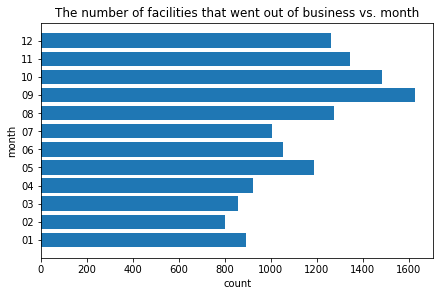

In [178]:
fig, axs = plt.subplots(1, 1, constrained_layout=True)
axs.set_title('The number of facilities that went out of business vs. month')
axs.set_xlabel('count')
axs.set_ylabel('month')
axs.barh(df_month['month'],df_month['Count'])

### **Number of inspections vs. average risk score**

We plotted the number of inspections vs. the average risk score of each facility to identify any possible correlation between the two. We observed the there is a negative correlation between the number of inspections and the average risk of the facility:

In [0]:
# Calculate risk mean of each facility
df_avg_risk_score = df.groupby(['Latitude','Longitude','DBA Name'])['Risk'].mean()

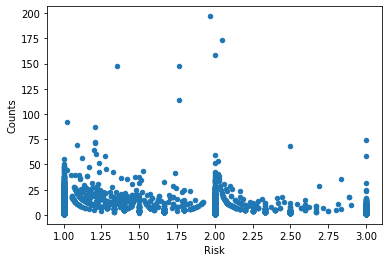

In [180]:
# Scatter plot on the number of inspections vs. the average risk score
df_unique = pd.DataFrame(df.groupby(['Latitude','Longitude','DBA Name']).count()['Risk']).rename(columns={'Risk':'Counts'})
merged = pd.merge(left=df_avg_risk_score.reset_index(),right=df_unique.reset_index(),left_on=['Latitude','Longitude','DBA Name'],right_on=['Latitude','Longitude','DBA Name'])
merged.plot.scatter(x='Risk', y='Counts')

We observed that the number of risk 3 facilities are lower than the others. Hence, we decided to plot average risk scores vs number of facilities.

### **Correlation between Number of Inspections and Average Level of Risk**

We observed a moderate positive correlation between the number of inspections and average level of risk of the facility (since Risk 1 means high risk and Risk 3 means low risk):

In [181]:
merged[['Risk', 'Counts']].corr(method='pearson')

,Risk,Counts
Risk,1.000000,-0.365569
Counts,-0.365569,1.000000


In [182]:
merged[['Risk', 'Counts']].corr(method='spearman')

,Risk,Counts
Risk,1.000000,-0.433247
Counts,-0.433247,1.000000


### **Distribution of Risk Scores of Facilities**

In [183]:
# Grouped by risk scores and number of facilities
df_avg_risk_score1 = pd.DataFrame(df_avg_risk_score).apply(lambda x: round(x)).reset_index()
df_avg_risk_score1 = pd.DataFrame(df_avg_risk_score1.groupby('Risk').count()['Latitude']).rename(columns={'Latitude':'Counts'})
df_avg_risk_score1

,Counts
Risk,
1.0,15581
2.0,6720
3.0,4688


We visualized the distribution of average level of risk scores of each facility using the bar plot below:

Text(0, 0.5, 'Number of facilities')

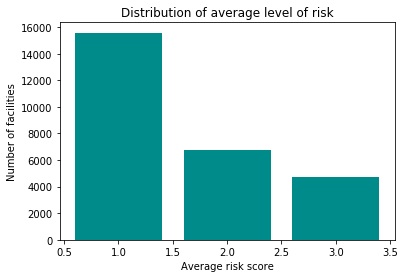

In [184]:
plt.bar(df_avg_risk_score1.index,df_avg_risk_score1['Counts'], color='darkcyan')
plt.title('Distribution of average level of risk')
plt.xlabel('Average risk score')
plt.ylabel('Number of facilities')

### **Type of Facility vs. Percentage of Going Out of Business**

In [185]:
# Data grouped by the facility type
fac_dist.head()

,Facility Type,Counts
0,RESTAURANT,131852
1,RETAIL STORE,25635
2,SCHOOL,12054
3,DAYCARE,9537
4,BAKERY,2923


In [0]:
# Group out of business facilities on facility type
df_oob_fac = pd.DataFrame(df_oob.groupby('Facility Type').count().rename(columns={'Risk':'Counts'})['Counts'])
merged_fac_oob = pd.merge(left=df_oob_fac.reset_index(), right=fac_dist.reset_index(),left_on=['Facility Type'],right_on=['Facility Type'])

In [187]:
merged_fac_oob.head()

,Facility Type,Counts_x,index,Counts_y
0,ASSISTED LIVING/NURSING HOME,4,21,95
1,BAKERY,249,4,2923
2,BANQUET,19,13,338
3,BAR,6,24,81
4,BUTCHER,5,34,34


In [0]:
merged_fac_oob['Oob Ratio'] = merged_fac_oob['Counts_x'].divide(merged_fac_oob['Counts_y'], fill_value=1)

In [189]:
merged_fac_oob.sort_values(by='Oob Ratio', ascending=False).drop(columns='index').head()

,Facility Type,Counts_x,Counts_y,Oob Ratio
30,PANTRY,5,9,0.555556
14,DISTRIBUTION,3,10,0.300000
41,WAREHOUSE,2,13,0.153846
4,BUTCHER,5,34,0.147059
18,HERBAL,6,47,0.127660


In [190]:
merged_fac_oob[['Oob Ratio', 'Counts_y']].corr(method='pearson')

,Oob Ratio,Counts_y
Oob Ratio,1.000000,-0.042375
Counts_y,-0.042375,1.000000


We wanted to identify a possible correlation between the type of facility and the percentage of going out of business. However, when we calculated the pearson's correlation factor, we observed no correlation.

### **Percentage of Going Out of Business vs. Average Risk Score**

In [0]:
# Merge the out of business facility types with their average risk scores
fac_oob_risk = pd.merge(left=merged_fac_oob.reset_index(), right=grouped_fac_risk_mean.reset_index(),left_on=['Facility Type'],right_on=['Facility Type'])

In [192]:
fac_oob_risk.drop(columns=['index_x', 'index_y']).rename(columns={'Counts_x':'Oob Count', 'Counts_y':'Total Count'}).head()

,level_0,Facility Type,Oob Count,Total Count,Oob Ratio,Risk
0,0,ASSISTED LIVING/NURSING HOME,4,95,0.042105,1.000000
1,1,BAKERY,249,2923,0.085186,1.629490
2,2,BANQUET,19,338,0.056213,1.118343
3,3,BAR,6,81,0.074074,2.135802
4,4,BUTCHER,5,34,0.147059,2.029412


In [193]:
fac_oob_risk[['Oob Ratio', 'Risk']].corr(method='pearson')

,Oob Ratio,Risk
Oob Ratio,1.000000,0.202511
Risk,0.202511,1.000000


In [194]:
fac_oob_risk[['Oob Ratio', 'Risk']].corr(method='spearman')

,Oob Ratio,Risk
Oob Ratio,1.000000,0.164878
Risk,0.164878,1.000000


We wanted to identify a possible correlation between the out of business ratio and the risk of the type of facility. However, when we calculated the pearson's correlation factor, we observed no correlation.



## **Violation Type Analysis**

### **Violations analysis - facilities that have gone out of business**

In [195]:
df_oob_unique.head()

,,,Inspection ID,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Location,Regions
Latitude,Longitude,DBA Name,,,,,,,,,,,,,
41.644670,-87.540095,BURGER KING,1,1,1,1,1,1,1,1,1,1,0,1,1
41.645667,-87.542510,SOUTH SHORE CONCESSIONS,1,1,1,1,1,1,1,1,1,1,0,1,1
41.646371,-87.560342,WINJAMMER MARINA,1,1,1,1,1,1,1,1,1,1,0,1,1
41.646554,-87.617083,SIR CHICKEN,1,0,1,1,1,1,1,1,1,1,0,1,1
41.648189,-87.561573,PAPICHULO,1,1,1,1,1,1,1,1,1,1,0,1,1


In [196]:
# Unique facilities that have gone out of business
merged_oob = pd.merge(left=df_oob_unique[['Latitude', 'Longitude', 'DBA Name']], right=df, on=['Latitude', 'Longitude', 'DBA Name'])

KeyError: ignored

In [0]:
# Out of business facilities that have more than 1 inspection
dup_oob = merged_oob.groupby(['Latitude', 'Longitude', 'DBA Name']).filter(lambda x : len(x) > 1)
dup_oob.dropna(subset=['Violations'], inplace=True) # the inspections that have violations (out of business facilities)
dup_oob.head(10)

In [0]:
# Split the violations column entries to obtain only the violation type numbers
violations_oob = dup_oob['Violations'].apply(lambda x: re.findall(r'^[0-9]+[.] | [|] [0-9]+[.] ', x))
violations_oob = pd.DataFrame(violations_oob)
violation_nums_oob = violations_oob['Violations'].apply(lambda x: [int(sub.replace('|','').split('.')[0]) for sub in x])\

In [0]:
# Format the list into a proper dataframe
violation_nums_oob = pd.DataFrame(violation_nums_oob)
violation_nums_oob.reset_index(inplace=True)
violation_nums_oob.drop(columns='index', inplace=True)
violation_nums_oob.head(10)

In [0]:
# Store the count of each type of violation in OOB facilities in a dictionary
vio_freq_oob = {}
for i in violation_nums_oob['Violations']:
  for j in i:
    vio_freq_oob[str(j)] = 1 if str(j) not in vio_freq_oob else vio_freq_oob[str(j)]+1

In [0]:
# Sort the violation types in terms of their frequencies
sorted_vio_freq_oob = {}

for key in sorted(vio_freq_oob, key=vio_freq_oob.__getitem__, reverse=True):
  sorted_vio_freq_oob[key] = vio_freq_oob[key]

In [0]:
# Display the violation type distribution in descending order of frequency
plt.figure(figsize=(17,4))
plt.bar(list(sorted_vio_freq_oob.keys()), sorted_vio_freq_oob.values())
plt.title('Violation Types vs. Their Frequencies in Out of Business Facilities')
plt.xlabel('Violation Types')
plt.ylabel('Frequency')
plt.show()

We observe that certain violation types outnumber others, but these ones are mostly non-critical or non-serious. We will plot only the serious and critical violations in the following sections to get the most important violations and their possible influence on causing establishments go out of business.

In [0]:
most_freq_vio_oob = [key for key, value in list(sorted_vio_freq_oob.items())[0:15]]
most_freq_vio_oob # top 10 most frequent violation types among facilities that went out of business

### **Violations analysis - facilities that have not gone out of business**

In [0]:
# Inspections of facilities that didn't go out of business
 set_diff_oob = pd.concat([df, merged_oob, merged_oob], sort=True).drop_duplicates(keep=False, subset=['Latitude', 'Longitude', 'DBA Name', 'Inspection Date'])

In [0]:
# set_diff_oob: the inspections that have violations (not out of business facilities)
set_diff_oob.dropna(subset=['Violations'], inplace=True)
set_diff_oob.head(10)

In [0]:
# Split the violations column entries to obtain only the violation type numbers
violations_not_oob = set_diff_oob['Violations'].apply(lambda x: re.findall(r'^[0-9]+[.] | [|] [0-9]+[.] ', x))
violations_not_oob = pd.DataFrame(violations_not_oob)
violation_nums_not_oob = violations_not_oob['Violations'].apply(lambda x: [int(sub.replace('|','').split('.')[0]) for sub in x])

In [0]:
# Format the list into a proper dataframe
violation_nums_not_oob = pd.DataFrame(violation_nums_not_oob)
violation_nums_not_oob.reset_index(inplace=True)
violation_nums_not_oob.drop(columns='index', inplace=True)
violation_nums_not_oob.head(10)

In [0]:
# Store the count of each type of violation in not OOB facilities in a dictionary
vio_freq_not_oob = {}
for i in violation_nums_not_oob['Violations']:
  for j in i:
    vio_freq_not_oob[str(j)] = 1 if str(j) not in vio_freq_not_oob else vio_freq_not_oob[str(j)]+1

In [0]:
# Sort the violation types in terms of their frequencies
sorted_vio_freq_not_oob = {}

for key in sorted(vio_freq_not_oob, key=vio_freq_not_oob.__getitem__, reverse=True):
  sorted_vio_freq_not_oob[key] = vio_freq_not_oob[key]

In [0]:
# Display the violation type distribution in descending order of frequency
plt.figure(figsize=(17,4))
plt.bar(list(sorted_vio_freq_not_oob.keys()), sorted_vio_freq_not_oob.values())
plt.title('Violation Types vs. Their Frequencies in Facilities that have not Gone Out of Business')
plt.xlabel('Violation Types')
plt.ylabel('Frequency')
plt.show()

In [0]:
most_freq_vio_not_oob = [key for key, value in list(sorted_vio_freq_not_oob.items())[0:15]]
most_freq_vio_not_oob # top 10 most frequent violation types among facilities that went out of business

In [0]:
merged_oob.dropna(subset=['Violations'], inplace=True) # the inspections that have violations (out of business facilities)

Our aim was to detect any violation type that could result into the facilities going out of business. From our data analysis, we found that most violation types are common between those that went out of business and those that have not. Only Violation Types 21, 31, and 43 are more prevalent in facilities that have gone out of business, but are not so prevalent in those that have not gone out of business.

### **Distribution of number of violations committed in each inspection (in facilities that went out of business)**

In [0]:
num_vio_oob = []
for i in violation_nums_oob['Violations']:
  num_vio_oob.append(len(i))

In [0]:
plt.hist(num_vio_oob, bins=15)
plt.title('Distribution of number of violations committed in each inspection (in oob facilities)')
plt.xlabel('Number of violations committed in an inspection')
plt.ylabel('Inspection counts')
plt.show()

In [0]:
print('Average number of violations committed in each inspection (OOB): ' + str(np.mean(num_vio_oob)))
print('Median number of violations committed in each inspection (OOB): ' + str(np.median(num_vio_oob)))

### **Distribution of number of violations committed in each inspection (in facilities that did NOT go out of business)**

In [0]:
num_vio_not_oob = []
for i in violation_nums_not_oob['Violations']:
  num_vio_not_oob.append(len(i))

In [0]:
plt.hist(num_vio_not_oob, bins=15)
plt.title('Distribution of number of violations committed in each inspection (in NOT oob facilities)')
plt.xlabel('Number of violations in committed in an inspection')
plt.ylabel('Inspection counts')
plt.show()

In [0]:
print('Average number of violations committed in each inspection (not OOB): ' + str(np.mean(num_vio_not_oob)))
print('Median number of violations committed in each inspection (not OOB): ' + str(np.median(num_vio_not_oob)))

We observe that the average number of violations committed in each inspection in facilities that went out of business is slightly higher than those that have not gone out of business. 

### **Distribution of total number of violations facilities commit before going out of business**

In [0]:
dup_oob['Violations'].update(violation_nums_oob['Violations'])
dup_oob['Number of Violations'] = dup_oob.Violations.apply(lambda x: len(x)) # create num of violations column
dup_oob.head(10)

In [0]:
sum_vios = dup_oob.groupby(['DBA Name', 'Latitude', 'Longitude'])['Number of Violations'].sum()
sum_vios.hist(bins=20)
plt.title('Distribution of total number of violations committed before going out of business')
plt.xlabel('Total number of committed violations')
plt.ylabel('Facility counts')
plt.show()

### **Average risk of oob facilities vs. Average risk of NOT oob facilities**

In [0]:
# Average risk of out of business facilities
merged_oob['Risk'].mean()

In [0]:
# Average risk of NOT out of business facilities
set_diff_oob['Risk'].mean()  

### **Region vs. Risk Score**

In [0]:
df_region = df.groupby('Regions')['Risk'].mean()
df_region.to_frame().nsmallest(10, 'Risk')

In [0]:
df_region.to_frame().nlargest(10, 'Risk')

In [0]:
# TODO: combine this with the percentage(?) of OOB, average # violations, and then rank
# TODO: run knn (or any unsupervised classification) algorithm to cluster neighborhoods, see if it clustered into meaningful clusters

In [0]:
df_region_fac = df.groupby(['Regions', 'Facility Type'])['Risk'].mean()

### **Violation Type Numbers and Their Description**

Violations numbered 1-44 and 70.

Violation #1-14: critical

Violation #15-29: serious 

In [0]:
df_nan_removed_vio = df.dropna(subset=['Violations'])
dict_vio = {}

for j in df_nan_removed_vio['Violations']:
  vio_list = j.split(" | ")
  for i in vio_list:
    result = i[i.find("[0-9]+[. ]")+1 : i.find(" - Comments")]
    vio_pair = result.split(".")
    if(vio_pair[0] not in dict_vio):
      dict_vio[vio_pair[0]] = vio_pair[1]

print(len(dict_vio)) 

dict_vio_sorted = {int(k):v for k,v in dict_vio.items()}
print(sorted(dict_vio_sorted))

pd.set_option('display.max_colwidth', -1) #to display the whole descriptions
vio_descr = pd.DataFrame(list(dict_vio_sorted.items())).rename(columns={0:'Violation Number', 1:'Description'}).sort_values(by=['Violation Number']).set_index('Violation Number')
vio_descr.head(50)

In [0]:
print(len(vio_descr))

In [0]:
merged_oob # facilities that have gone oob
set_diff_oob # facilities that haven't gone oob
critical_vios = list(range(15))
serious_vios = list(range(15, 30))

In [0]:
merged_oob.dropna(subset=['Violations'], inplace=True)
merged_oob['Violations'] = merged_oob['Violations'].apply(lambda x: re.findall(r'^[0-9]+[.] | [|] [0-9]+[.] ', x))
merged_oob['Violations'] = merged_oob['Violations'].apply(lambda x: [int(sub.replace('|','').split('.')[0]) for sub in x])
merged_oob['Violations'] = merged_oob['Violations'].apply(lambda x: [x for x in x if x in critical_vios + serious_vios])

In [0]:
vio_crit_serious_oob = pd.DataFrame(merged_oob)
vio_crit_serious_oob.reset_index(inplace=True)
vio_crit_serious_oob.drop(columns='index', inplace=True)

vio_freq_crit_serious_oob = {}
for i in vio_crit_serious_oob['Violations']:
  for j in i:
    vio_freq_crit_serious_oob[str(j)] = 1 if str(j) not in vio_freq_crit_serious_oob else vio_freq_crit_serious_oob[str(j)]+1

sorted_vio_freq_crit_serious_oob = {}

for key in sorted(vio_freq_crit_serious_oob, key=vio_freq_crit_serious_oob.__getitem__, reverse=True):
  sorted_vio_freq_crit_serious_oob[key] = vio_freq_crit_serious_oob[key]

num_oob_inspections = len(merged_oob)
num_oob_inspections

In [0]:
set_diff_oob.dropna(subset=['Violations'], inplace=True)
set_diff_oob['Violations'] = set_diff_oob['Violations'].apply(lambda x: re.findall(r'^[0-9]+[.] | [|] [0-9]+[.] ', x))
set_diff_oob['Violations'] = set_diff_oob['Violations'].apply(lambda x: [int(sub.replace('|','').split('.')[0]) for sub in x])
set_diff_oob['Violations'] = set_diff_oob['Violations'].apply(lambda x: list(set([x for x in x if x in critical_vios + serious_vios])))

In [0]:
vio_crit_serious_not_oob = pd.DataFrame(set_diff_oob)
vio_crit_serious_not_oob.reset_index(inplace=True)
vio_crit_serious_not_oob.drop(columns='index', inplace=True)

vio_freq_crit_serious_not_oob = {}
for i in vio_crit_serious_not_oob['Violations']:
  for j in i:
    vio_freq_crit_serious_not_oob[str(j)] = 1 if str(j) not in vio_freq_crit_serious_not_oob else vio_freq_crit_serious_not_oob[str(j)]+1

sorted_vio_freq_crit_serious_not_oob = {}

for key in sorted(vio_freq_crit_serious_not_oob, key=vio_freq_crit_serious_not_oob.__getitem__, reverse=True):
  sorted_vio_freq_crit_serious_not_oob[key] = vio_freq_crit_serious_not_oob[key]

num_not_oob_inspections = len(set_diff_oob)
num_not_oob_inspections

In [0]:
ratio_crit_serious_oob = {k: v / num_oob_inspections for k, v in sorted_vio_freq_crit_serious_oob.items()}
ratio_crit_serious_not_oob = {k: v / num_not_oob_inspections for k, v in sorted_vio_freq_crit_serious_not_oob.items()}

In [0]:
plt.figure(figsize=(10,4))
Facilities=['Not OOB','OOB']
plt.bar(list(ratio_crit_serious_not_oob.keys()), ratio_crit_serious_not_oob.values(),color='mediumorchid',edgecolor='black')
plt.bar(list(ratio_crit_serious_oob.keys()), ratio_crit_serious_oob.values(),color='lightseagreen',edgecolor='black')
plt.title('Ratios of committed critical and serious violations')
plt.xlabel('Violation Types')
plt.ylabel('Ratio (out of all inspections)')
plt.legend(Facilities,loc=1)
plt.show()

In [0]:
X = ratio_crit_serious_oob.keys()
Y = ratio_crit_serious_oob.values()
Z = ratio_crit_serious_not_oob.values()
plt.figure(figsize=(18,6))

def subcategorybar(X, vals, width=0.8):
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge")   
    plt.xticks(_X, X)

Facilities=['OOB','Not OOB']
subcategorybar(X, [Y,Z])
plt.title('Ratios of committed critical and serious violations',fontsize=24)
plt.xlabel('Violation Types',fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Ratio (out of all inspections)',fontsize=20)
plt.yticks(fontsize=20)
plt.legend(Facilities,loc=1,fontsize=20)
plt.show()

In [0]:
most_freq_crit_serious_oob_15 = [key for key, value in list(sorted_vio_freq_crit_serious_oob.items())[0:15]]
most_freq_crit_serious_oob_10 = [key for key, value in list(sorted_vio_freq_crit_serious_oob.items())[0:10]]
most_freq_crit_serious_oob_5 = [key for key, value in list(sorted_vio_freq_crit_serious_oob.items())[0:5]]
# top 10 and 5 most frequent violation types among facilities that went out of business

In [0]:
most_freq_crit_serious_not_oob_15 = [key for key, value in list(sorted_vio_freq_crit_serious_not_oob.items())[0:15]]
most_freq_crit_serious_not_oob_10 = [key for key, value in list(sorted_vio_freq_crit_serious_not_oob.items())[0:10]]
most_freq_crit_serious_not_oob_5 = [key for key, value in list(sorted_vio_freq_crit_serious_not_oob.items())[0:5]]
# top 15, 10 and 5 most frequent violation types among facilities that didn't go out of business

In [0]:
# The difference of top 5 most frequent critical and serious violation types between oob and not oob facilities
crit_serious_diff_5 = list(set(most_freq_crit_serious_oob_5) - set(most_freq_crit_serious_not_oob_5))
crit_serious_diff_5

Violation number 29 might be an important factor in making facilities go out of business. So we check its description: 

29 - COMPLIANCE WITH VARIANCE/SPECIALIZED PROCESS/HACCP.

In [0]:
# The difference of top 10 most frequent critical and serious violation types between oob and not oob facilities
crit_serious_diff_10 = list(set(most_freq_crit_serious_oob_10) - set(most_freq_crit_serious_not_oob_10))
crit_serious_diff_10

Violation number 24, 11, and 19 might be important factors in making facilities go out of business. So we check their descriptions: 

24 - TIME AS A PUBLIC HEALTH CONTROL; PROCEDURES & RECORDS

11 - FOOD OBTAINED FROM APPROVED SOURCE

19 - PROPER REHEATING PROCEDURES FOR HOT HOLDING

In [0]:
# The difference of top 15 most frequent critical and serious violation types between oob and not oob facilities
crit_serious_diff_15 = list(set(most_freq_crit_serious_oob_15) - set(most_freq_crit_serious_not_oob_15))
crit_serious_diff_15

In [0]:
vio_freq_all = {}
for i in violation_nums_oob['Violations']:
  for j in i:
    vio_freq_oob[str(j)] = 1 if str(j) not in vio_freq_oob else vio_freq_oob[str(j)]+1